In [18]:
import random
import time
import os.path as osp
from pathlib import Path
from typing import Tuple
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
import dask as d
import keras_tuner as kt

from tensorflow.python.client import device_lib
from tensorflow.keras import backend, Input, Model, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

from fl_tissue_model_tools.transforms import get_elastic_dual_transform
from fl_tissue_model_tools.preprocessing import get_augmentor, get_batch_augmentor
from fl_tissue_model_tools import models
from fl_tissue_model_tools.helper import get_img_mask_paths

# Validate data paths

In [23]:
images_dir = "./images"
labels_dir = "./masks"
image_mask_paths = get_img_mask_paths(images_dir, labels_dir)
img_paths, mask_paths = zip(*image_mask_paths)

print(f"Found {len(image_mask_paths)} image/label pairs")

Found 31 image/label pairs


In [24]:
for img_path, mask_path in image_mask_paths:
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, 0)

    assert image.shape == mask.shape, (
        f"Image {img_path} and mask {mask_path} have different shapes: {image.shape} vs {mask.shape}"
    )

    if np.unique(mask).tolist() not in ([0], [255], [0, 255]):
        print(f"Mask {mask_path} has unexpected values: {np.unique(mask)}")

# Constants

In [25]:
rand_seed = 12345
batch_size = 2
og_img_shape = (1992, 1992)         # shape of the original images
crop_size = (512, 512)              # shape of the cropped images
ds_img_shape = (256, 256)           # shape of the downsampled images
n_outputs = 1
cls_thresh = 0.5
filter_counts_options = [
    (8, 16, 32, 64),
    (16, 32, 64, 128),
    (32, 64, 128, 256),
    (64, 128, 256, 512)
]

# Data pipeline

In [29]:
def load_y(batch_mask_paths):
    # Load the binary segmentation masks
    y = np.array([cv2.imread(mask_path, 0) for mask_path in batch_mask_paths])
    y[y>0] = 1
    return y

def load_x(batch_img_paths):
    # Load the input images
    x = [cv2.imread(img_path, 0) for img_path in batch_img_paths]
    return np.array(x)

class BinaryMaskSequence(Sequence):
    """Helper to iterate over the data"""

    def __init__(self, batch_size, img_paths, seg_paths, random_state,
                load_x, load_y, augmentation_function=None, sample_weights=None,
                repeat_n_times=1, shuffle=True):
        self.batch_size = batch_size
        self.img_paths = img_paths
        self.seg_paths = seg_paths
        self.rs: np.random.RandomState = random_state
        self.load_x = load_x
        self.load_y = load_y
        self.sample_weights = sample_weights
        if sample_weights:
            self.fg_weight = sample_weights[1]
            self.bg_weight = sample_weights[0]
        self.repeat_n_times = repeat_n_times
        self.shuffle = shuffle
        self.augmentation_function = augmentation_function

    def __len__(self):
        return (len(self.seg_paths) // self.batch_size) * self.repeat_n_times

    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        if self.repeat_n_times > 1:
            i = (idx * self.batch_size) % len(self.img_paths)
        else:
            i = idx * self.batch_size

        batch_img_paths = self.img_paths[i : i + self.batch_size]
        batch_seg_paths = self.seg_paths[i : i + self.batch_size]

        if self.shuffle or self.repeat_n_times > 1:
            remaining_samples_at_i = len(self.img_paths) - i
            if remaining_samples_at_i < self.batch_size:
                batch_img_paths += self.img_paths[0:self.batch_size - remaining_samples_at_i]
                batch_seg_paths += self.seg_paths[0:self.batch_size - remaining_samples_at_i]

        if self.shuffle:
            # Shuffle the data keeping pairs together
            indices = self.rs.permutation(len(self.img_paths))
            self.img_paths = [self.img_paths[i] for i in indices]
            self.seg_paths = [self.seg_paths[i] for i in indices]

        x, y = d.compute([
            d.delayed(self.load_x)(batch_img_paths),
            d.delayed(self.load_y)(batch_seg_paths)
        ])[0]

        if self.augmentation_function is not None:
            x, y = self.augmentation_function(x, y)

        x = x[..., np.newaxis]
        y = y[..., np.newaxis]

        # If want to up/down-weight foreground/background pixel loss
        # This is good for images that tend to be imbalanced between foreground
        # and background pixel area.
        if self.sample_weights:
            batch_sample_weights = np.zeros(shape=y.shape)
            batch_sample_weights[y == 1] = self.fg_weight
            batch_sample_weights[y != 1] = self.bg_weight
            return x, y, batch_sample_weights

        return x, y

# Augmentation Pipeline

In [30]:
def get_downsampler(ds_shape):
    def ds_im_mask(image, mask):
        """Use pillow to downscale image with lanczos interpolation and mask with nearest neighbor"""
        image = np.array(Image.fromarray(image).resize(ds_shape, resample=Image.Resampling.LANCZOS))
        mask = np.array(Image.fromarray(mask).resize(ds_shape, resample=Image.Resampling.NEAREST))
        return {'image': image, 'mask': mask}
    return ds_im_mask

def get_normalizer(mean, std):
    def norm_im(image, mask):
        """Normalize image with mean and std of training set images"""
        image = ((image - mean) / std).astype(np.float32)
        return {'image': image, 'mask': mask}
    return norm_im

def get_train_transforms(crop_size, ds_img_shape, mean, std):
    train_transforms = [
        A.Compose([
            A.Rotate(p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
            A.RandomCrop(height=crop_size[0], width=crop_size[1]),
            A.Flip(p=0.5),
            A.OneOf([
                    A.MultiplicativeNoise(p=0.5),
                    A.AdvancedBlur(p=0.5)
            ], p=0.8),
            A.OneOf([
                A.RandomGamma(p=0.2),
                A.RandomBrightnessContrast(p=0.4),
                A.RandomToneCurve(scale=0.75, p=0.2),
                A.CLAHE(p=0.2)
            ], p=0.75)
        ]),     # Albumentations pipeline
        get_elastic_dual_transform(),    # Elastic distortion at the end
        get_downsampler(ds_img_shape),
        get_normalizer(mean, std)
    ]
    return train_transforms

def get_val_transforms(crop_size, ds_img_shape, mean, std):
    val_transforms = [
        A.Compose([
            A.RandomCrop(height=crop_size[0], width=crop_size[1]),
            A.Flip(p=0.5),
            A.RandomRotate90(p=0.5)
        ]),
        get_downsampler(ds_img_shape),
        get_normalizer(mean, std)
    ]
    return val_transforms

# Set up data generators

In [31]:
n_val = int(len(img_paths) * 0.2)

# Shuffle the data image/mask keeping pairs together

#indices = np.random.permutation(len(img_paths))    # non-seeded random shuffle
rs = np.random.RandomState(seed=rand_seed)
indices = rs.permutation(len(img_paths))

img_paths = [img_paths[i] for i in indices]
mask_paths = [mask_paths[i] for i in indices]

In [32]:
train_img_paths = img_paths[: -n_val]
train_mask_paths = mask_paths[:-n_val]

val_img_paths = img_paths[-n_val:]
val_mask_paths = mask_paths[-n_val:]

test_img_paths = []
test_mask_paths = []

## Compute sample weights & mean/std for training data

In [33]:
y_train_labels = load_y(train_mask_paths)

In [34]:
n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}
sample_weights

{0: 0.5261849711902462, 1: 10.04746133511592}

In [35]:
# Get the mean and std of the training set images
x_train_imgs = load_x(img_paths)
im_mean = np.mean(x_train_imgs)
im_std = np.std(x_train_imgs)

In [36]:
im_mean, im_std

(70.2545392169143, 62.80519937509883)

In [48]:
# Augmentation
train_transforms = get_train_transforms(crop_size, ds_img_shape, im_mean, im_std)
val_transforms = get_val_transforms(crop_size, ds_img_shape, im_mean, im_std)
train_augmentor = get_batch_augmentor(train_transforms)
val_augmentor = get_batch_augmentor(val_transforms)

In [49]:
rs = np.random.RandomState(seed=rand_seed)

train_gen = BinaryMaskSequence(
    batch_size, train_img_paths, train_mask_paths,
    rs, load_x, load_y, augmentation_function=train_augmentor,
    sample_weights=sample_weights,
    repeat_n_times=50, shuffle=True)

val_gen = BinaryMaskSequence(
    batch_size, val_img_paths, val_mask_paths,
    rs, load_x, load_y, augmentation_function=val_augmentor,
    sample_weights=sample_weights,
    repeat_n_times=50, shuffle=True)

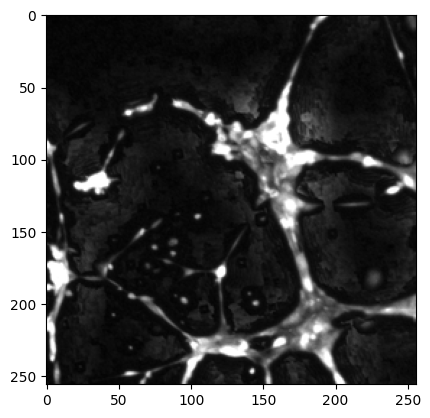

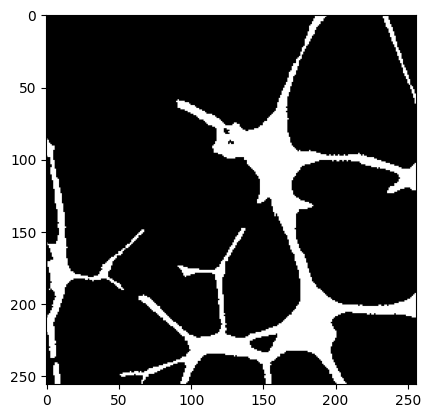

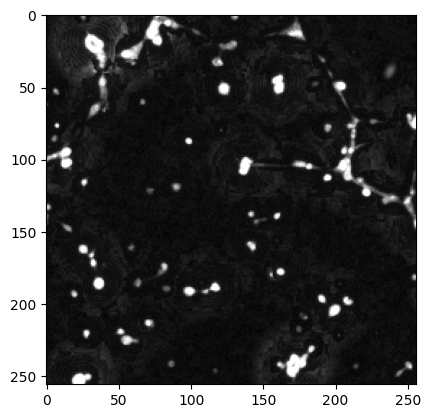

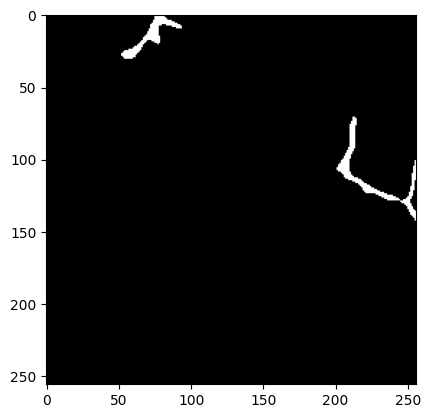

In [50]:
# Test the generators
X, y, _ = train_gen[1]
for i in range(batch_size):
    plt.imshow(X[i][:,:,0], cmap='gray')
    plt.show()
    plt.imshow(y[i][:,:,0], cmap='gray')
    plt.show()

# Run grid search

In [52]:
# make sure tensorflow is using the GPU
print(device_lib.list_local_devices())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15875451506149615403
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4664983552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12945928050274595638
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [56]:
backend.clear_session()

initial_learning_rate = 2.5e-4
cycle_steps = 500

lr_schedule = CosineDecayRestarts(initial_learning_rate, cycle_steps, t_mul=2.0, m_mul=0.75)

optimizer = AdamW(learning_rate=lr_schedule)

n_epochs = 5

metrics=[models.mean_iou_coef_factory(thresh=cls_thresh), get_lr_metric(optimizer)]

gs = models.UNetXceptionGridSearch(
    "oxford_pets_grid_search",
    filter_counts_options,
    n_outputs,
    ds_img_shape,
    optimizer=optimizer,
    loss=BinaryCrossentropy(),
    output_act="sigmoid",
    
)

gs.search(
    "mean_iou_coef",
    "max",
    train_gen,
    search_verbose=True,
    validation_data=val_gen,
    epochs=n_epochs
)

Testing filter counts: (64, 128, 256, 512)
Epoch 1/25
600/600 [==============================] - 77s 117ms/step - loss: 0.5015 - mean_iou_coef: 0.2247 - lr: 1.3537e-04 - val_loss: 1.0195 - val_mean_iou_coef: 0.1301 - val_lr: 1.8300e-04
Epoch 2/25
600/600 [==============================] - 70s 116ms/step - loss: 0.2826 - mean_iou_coef: 0.2703 - lr: 1.1874e-04 - val_loss: 0.4131 - val_mean_iou_coef: 0.1755 - val_lr: 3.8884e-05
Epoch 3/25
600/600 [==============================] - 70s 117ms/step - loss: 0.2426 - mean_iou_coef: 0.2887 - lr: 7.5702e-05 - val_loss: 0.2880 - val_mean_iou_coef: 0.1740 - val_lr: 1.3301e-04
Epoch 4/25
600/600 [==============================] - 70s 117ms/step - loss: 0.2298 - mean_iou_coef: 0.3045 - lr: 1.1017e-04 - val_loss: 0.2829 - val_mean_iou_coef: 0.2349 - val_lr: 8.1421e-05
Epoch 5/25
600/600 [==============================] - 70s 116ms/step - loss: 0.2054 - mean_iou_coef: 0.3201 - lr: 4.9431e-05 - val_loss: 0.2489 - val_mean_iou_coef: 0.1619 - val_lr: 2.0

In [58]:
backend.clear_session()

initial_learning_rate = 2.5e-4
cycle_steps = 800

lr_schedule = CosineDecayRestarts(initial_learning_rate, cycle_steps, t_mul=2.0, m_mul=0.85)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = AdamW(learning_rate=lr_schedule)

n_epochs = 100

model = models.build_UNetXception(
    n_outputs,
    ds_img_shape,
    filter_counts=gs.best_filter_counts,
    output_act="sigmoid"
)

metrics=[models.mean_iou_coef_factory(thresh=cls_thresh), get_lr_metric(optimizer)]

model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=metrics)

gs = models.UNetXceptionGridSearch(
    "the_different_folder",
    filter_counts_options,
    n_outputs,
    ds_img_shape,
    optimizer=optimizer,
    loss=BinaryCrossentropy(),
    output_act="sigmoid",
    metrics=[models.mean_iou_coef_factory(thresh=cls_thresh), get_lr_metric(optimizer)]
)

gs.search(
    "mean_iou_coef",
    "max",
    train_gen,
    search_verbose=True,
    validation_data=val_gen,
    epochs=n_epochs
)

Testing filter counts: (64, 128, 256, 512)
Epoch 1/100
600/600 [==============================] - 81s 123ms/step - loss: 0.4304 - mean_iou_coef: 0.2399 - lr: 1.6269e-04 - val_loss: 0.6129 - val_mean_iou_coef: 0.1516 - val_lr: 3.6959e-05
Epoch 2/100
600/600 [==============================] - 74s 123ms/step - loss: 0.2941 - mean_iou_coef: 0.2628 - lr: 1.3882e-04 - val_loss: 0.3238 - val_mean_iou_coef: 0.1966 - val_lr: 1.8153e-04
Epoch 3/100
600/600 [==============================] - 74s 123ms/step - loss: 0.2414 - mean_iou_coef: 0.2953 - lr: 1.2590e-04 - val_loss: 0.2207 - val_mean_iou_coef: 0.2068 - val_lr: 6.5783e-05
Epoch 4/100
600/600 [==============================] - 74s 123ms/step - loss: 0.1986 - mean_iou_coef: 0.3174 - lr: 2.2982e-05 - val_loss: 0.2472 - val_mean_iou_coef: 0.2176 - val_lr: 2.0266e-10
Epoch 5/100
600/600 [==============================] - 74s 123ms/step - loss: 0.2448 - mean_iou_coef: 0.3015 - lr: 1.7550e-04 - val_loss: 0.4283 - val_mean_iou_coef: 0.1746 - val_lr

In [ ]:
gs.best_filter_counts

(64, 128, 256, 512)

In [ ]:
gs.best_score

0.3666583001613617

In [ ]:
gs.best_score_idx

0

# Load best weights

In [ ]:
best_model = gs.get_best_model()

In [ ]:
test_ex_batch = 12

In [ ]:
# test_example_x, test_example_y = val_gen[test_ex_batch]#test_gen[test_ex_batch]
test_example_x, test_example_y, _ = val_gen[test_ex_batch]#test_gen[test_ex_batch]

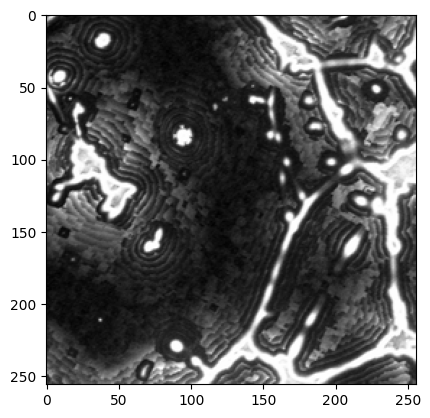

In [ ]:
plt.imshow(np.squeeze(test_example_x[0][:,:,0]), cmap='gray')

In [ ]:
test_preds = best_model.predict(test_example_x)

1/1 [==============================] - 0s 19ms/step


In [ ]:
test_ex_idx = 0
test_ex_img = test_example_x[test_ex_idx]
test_ex_pred = test_preds[test_ex_idx]
test_ex_true = test_example_y[test_ex_idx]

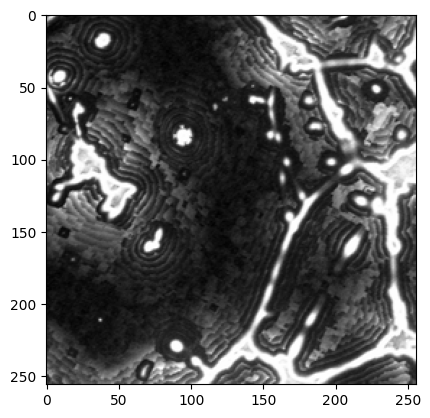

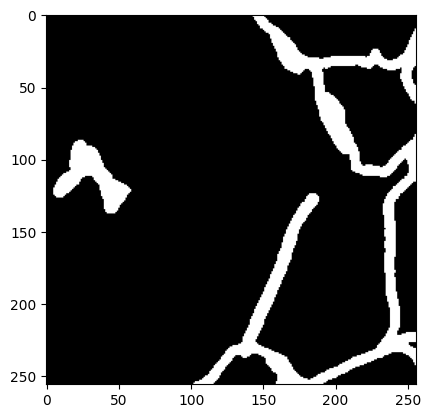

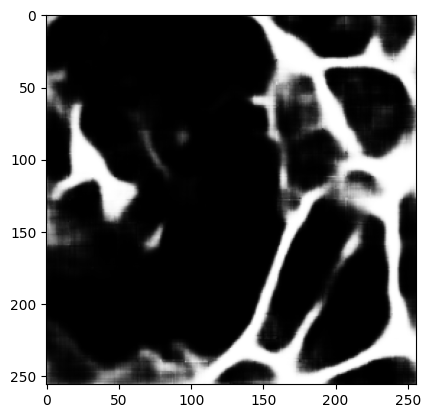

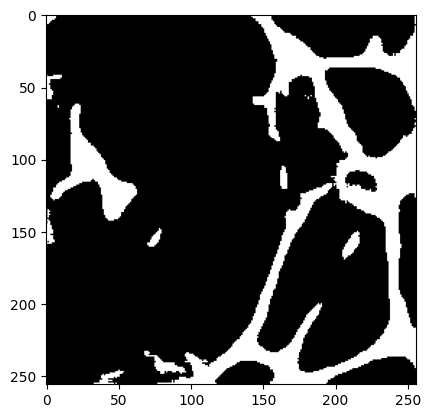

In [ ]:
plt.imshow(test_ex_img, cmap="gray")
plt.show()
plt.imshow(test_ex_true, cmap="gray")
plt.show()
plt.imshow(test_ex_pred, cmap="gray")
plt.show()
plt.imshow(np.greater(test_ex_pred, cls_thresh), cmap="gray")
plt.show()